<a href="https://colab.research.google.com/github/ykitaguchi77/Colab_Scripts/blob/master/Convert%20Pytorch%20Models%20to%20CoreML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Conversion of Pytorch script to CoreML**

既存のモデルを変換する場合<br>
https://coremltools.readme.io/docs/pytorch-conversion

In [2]:
import torch
import torchvision
!pip install coremltools
import coremltools as ct


# Load a pre-trained version of MobileNetV2
torch_model = torchvision.models.mobilenet_v2(pretrained=True)

# Set the model in evaluation mode
torch_model.eval()

# Trace with random data
example_input = torch.rand(1, 3, 224, 224) # after test, will get 'size mismatch' error message with size 256x256
traced_model = torch.jit.trace(torch_model, example_input)


# Download class labels (from a separate file)
import urllib
label_url = 'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
class_labels = urllib.request.urlopen(label_url).read().decode("utf-8").splitlines()
class_labels = class_labels[1:] # remove the first class which is background
assert len(class_labels) == 1000



# Convert to Core ML using the Unified Conversion API
mlmodel = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input_1", shape=example_input.shape)], #name "input_1" is used in 'quickstart'
    classifier_config = ct.ClassifierConfig(class_labels) # provide only if step 2 was performed
)

# Save model
mlmodel.save("MobileNetV2.mlmodel")

Translating MIL ==> MLModel Ops: 100%|██████████| 704/704 [00:00<00:00, 1547.83 ops/s]


In [ ]:
from torchsummary import summary
torch_model.to(device)
summary(torch_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

#**新しく学習を行う場合（MNISTの例）**<br>




参考サイト：<br>
https://qiita.com/shu223/items/6ddfbedb4fdfb2059a11<br>
https://chemicalfactory.hatenablog.com/entry/2020/01/26/230114

MNISTの学習

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



batch_size = 10

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transforms.Compose([transforms.Grayscale(), transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=0)

testset = torchvision.datasets.MNIST(root='./data', train=False, 
                                        download=True, transform=transforms.Compose([transforms.Grayscale(), transforms.Resize(28), transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=0)

class MNIST_Conv_MN(nn.Module):
    def __init__(self):
        super(MNIST_Conv_MN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) 
        self.pooling = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(13 * 13 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pooling(x)
        x = x.view(-1, 13 * 13 * 8)
        x = self.fc1(x)
        return x
    
model=MNIST_Conv_MN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

num_epochs = 10

for epoch in range(num_epochs):
    
    train_loss = 0
    train_acc = 0
    val_loss = 0
    val_acc = 0
    
    model.train()
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        train_loss += loss.item()
        train_acc += (outputs.max(1)[1] == labels).sum().item()
        loss.backward()
        optimizer.step()
    avg_train_loss = train_loss / len(trainloader.dataset)
    avg_train_acc = train_acc / len(trainloader.dataset)

    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.max(1)[1] == labels).sum().item()
        avg_val_loss = val_loss / len(testloader.dataset)
        avg_val_acc = val_acc / len(testloader.dataset)
        
        print("Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}"\
              .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
        
torch.save(model.state_dict(), "MNIST.pth")

Epoch [1/10], Loss: 0.0190, val_loss: 0.0091, val_acc: 0.9717
Epoch [2/10], Loss: 0.0084, val_loss: 0.0070, val_acc: 0.9781
Epoch [3/10], Loss: 0.0065, val_loss: 0.0069, val_acc: 0.9788
Epoch [4/10], Loss: 0.0054, val_loss: 0.0067, val_acc: 0.9799
Epoch [5/10], Loss: 0.0048, val_loss: 0.0066, val_acc: 0.9803
Epoch [6/10], Loss: 0.0042, val_loss: 0.0063, val_acc: 0.9807
Epoch [7/10], Loss: 0.0037, val_loss: 0.0068, val_acc: 0.9795
Epoch [8/10], Loss: 0.0034, val_loss: 0.0069, val_acc: 0.9801
Epoch [9/10], Loss: 0.0031, val_loss: 0.0063, val_acc: 0.9821
Epoch [10/10], Loss: 0.0027, val_loss: 0.0066, val_acc: 0.9819


MNISTをCoreMLに変換

In [ ]:
#import coreML ver4.0
!pip install -U coremltools
import coremltools as ct


class MNIST_Conv_MN(nn.Module):
    def __init__(self):
        super(MNIST_Conv_MN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3) 
        self.pooling = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(13 * 13 * 8, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pooling(x)
        x = x.view(-1, 13 * 13 * 8)
        x = self.fc1(x)
        return x

model = MNIST_Conv_MN()
model.load_state_dict(torch.load('MNIST.pth'))
model.eval()

scripted_model = torch.jit.script(model)

#サイズの合ったランダムな入力を行う
example_input = torch.rand(1,1,28,28)
traced = torch.jit.trace(model, example_input)

#class_labelの設定
class_labels = list(range(10))

#traced.save("model.pt")
mlmodel = ct.convert(
    traced, 
    inputs=[ct.TensorType(name="input_1", shape=example_input.shape)],
    classifier_config = ct.ClassifierConfig(class_labels) 
)
mlmodel.save('MNIST.mlmodel')

Requirement already up-to-date: coremltools in /usr/local/lib/python3.7/dist-packages (4.1)


Translating MIL ==> MLModel Ops: 100%|██████████| 19/19 [00:00<00:00, 2773.72 ops/s]


In [ ]:
from torchsummary import summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
         MaxPool2d-2            [-1, 8, 13, 13]               0
            Linear-3                   [-1, 10]          13,530
Total params: 13,610
Trainable params: 13,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.05
Estimated Total Size (MB): 0.11
----------------------------------------------------------------


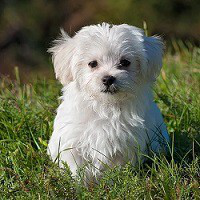

In [ ]:
from PIL import Image
img = Image.open("/content/pytorch-list-of-transforms_01.jpg")
display(img)
